In [1]:
import numpy as np
from scipy import linalg as la

We want to solve least squares for $u_i(t) \approx D(t)^T W_\text{out} r(t)$, for all values of $t$.

In [3]:
#Test problem
def full_function(X, Y, A):
    return np.einsum('tn,knm,tm->tk', X,A,Y)

X = np.random.random((40,2)) * 10
Y = np.random.random((40,3)) * 10
A = np.array([
    [
        [1, 1, 0],
        [0, 2, 1]
    ],
    [
        [4, 10, -3],
        [1, 80, 3]
    ]
])

u=full_function(X,Y,A)

In [4]:
#normally is A^T Ax = A^Ty
#we have something weird instead
def solve_ls(r, d, u, r_alpha=0, d_alpha=0):
    """
    Solves for the tensor Wout such that Wout(r(t),d(t)) \approx u(t), using Tikhanov regularization
    with parameters r_alpha and d_alpha (both default 0).
    d_alpha is currently unimplemented.
    The value of Wout(r(t),d(t)) can be computed with get_prediction(r, d, Wout).
    """
    tlen = r.shape[0]
    rlen = r.shape[1]
    dlen = d.shape[1]
    #this essentially takes the outer product of r and d at each timestep, and reshapes the result into a vector
    #   of length R*D. Then, sets up least-squares/Tikhonov regression.
    rd = np.einsum('tR,tD->tRD',r,d).reshape(tlen,-1)
    RDhat = np.einsum('tJ,tK->JK',rd,rd)#dr^Trd^T ish
    Uhat = np.einsum('tJ,tu->Ju', rd, u)#dr^Tu
    
    return la.solve(RDhat + r_alpha*np.eye(rlen*dlen), Uhat).reshape(rlen, dlen,-1).transpose([2,0,1])
    
def solve_ls_2p(r, d, u, r_alpha=0, d_alpha=0):
    """
    Solves for the tensor Wout such that Wout(r(t),d(t)) \approx u(t), using Tikhanov regularization
    with parameters r_alpha and d_alpha (both default 0). r_alpha is used for coefficients corresponding
    to d_alpha[0], and d_alpha to all others.
    The value of Wout(r(t),d(t)) can be computed with get_prediction(r, d, Wout).
    """
    tlen = r.shape[0]
    rlen = r.shape[1]
    dlen = d.shape[1]
    #this essentially takes the outer product of r and d at each timestep, and reshapes the result into a vector
    #   of length R*D. Then, sets up least-squares/Tikhonov regression.
    rd = np.einsum('tR,tD->tRD',r,d).reshape(tlen,-1)
    RDhat = np.einsum('tJ,tK->JK',rd,rd)
    Uhat = np.einsum('tJ,tu->Ju', rd, u)
    
    #r_alpha is used for coefficients corresponding to d_alpha[0], and d_alpha to all others.
    reg_matr = np.diag(([r_alpha]+(dlen-1)*[d_alpha]) * rlen)
    
    return la.solve(RDhat + reg_matr, Uhat).reshape(rlen, dlen,-1).transpose([2,0,1])
    


In [5]:
#Test case
Ahat = solve_ls(X,Y,u, r_alpha=1e-8)
print(Ahat)
print(Ahat.shape)
print(A.shape)
print(np.abs(Ahat-A))
np.allclose(Ahat, A)
Ahat2 = solve_ls_2p(X,Y,u, r_alpha=1e-8, d_alpha=1e-4)
print(np.abs(Ahat-A))


[[[ 1.00000000e+00  1.00000000e+00  2.10854714e-12]
  [ 2.89567869e-12  2.00000000e+00  1.00000000e+00]]

 [[ 4.00000000e+00  1.00000000e+01 -3.00000000e+00]
  [ 1.00000000e+00  8.00000000e+01  3.00000000e+00]]]
(2, 2, 3)
(2, 2, 3)
[[[2.79820611e-12 1.82298621e-13 2.10854714e-12]
  [2.89567869e-12 1.01185726e-12 1.57507341e-12]]

 [[3.51154661e-11 5.16138243e-11 1.74997794e-11]
  [3.84823284e-11 7.64543984e-11 3.86419785e-11]]]
[[[2.79820611e-12 1.82298621e-13 2.10854714e-12]
  [2.89567869e-12 1.01185726e-12 1.57507341e-12]]

 [[3.51154661e-11 5.16138243e-11 1.74997794e-11]
  [3.84823284e-11 7.64543984e-11 3.86419785e-11]]]


In [6]:
print(np.atleast_2d(np.arange(10)).shape)

(1, 10)


In [7]:
def get_prediction(r, d, Wout):
    return np.einsum('tR,tD,RuD->tu', r,d,Wout)

def get_prediction_1d(r, d, Wout):
    return np.einsum('R,D,RuD->u', r,d,Wout)

In [1]:
import numpy as np
from scipy import linalg as la
from scipy import integrate
from scipy.interpolate import CubicSpline
import rescomp as rc

In [2]:
class DrivenResComp2(rc.DrivenResComp):
    """
    Version of DrivenResComp that uses a different training method, in an attempt to better handle the drive state.
    Instead of using the drive state to affect the reservoir states, it's used along the reservoir states to predict.
    """
    def __init__(self, *args, drive_alpha=None, **kwargs):
        super().__init__(*args, **kwargs)
        
        #defaults to ridge_alpha
        if drive_alpha is None:
            self.drive_alpha = self.ridge_alpha
        else:
            self.drive_alpha = drive_alpha
        
        #Reset these to be the right size
        rd = self.res_sz * (1+self.drive_dim)
        self.Rhat = np.zeros((rd, rd))
        self.Yhat = np.zeros((rd, self.signal_dim))
    
    def res_f(self, t, r, u, d):
        """ ODE to drive the reservoir node states with u(t) and a input signal d(t) (unused here)"""
        transform_train = self.sigma * self.W_in @ u(t)
        return self.gamma * (-1 * r + self.activ_f(self.res @ r + transform_train))

    def res_pred_f(self, t, r, d):
        """ Reservoir prediction ode. Assumes precomputed W_out. Accepts an input signal d(t) """
        recurrence = self.sigma * self.W_in @ self._get_output_1d(r, d(t))
        return self.gamma*(-1*r + self.activ_f(self.res @ r + recurrence))
    
    def _get_output(self, r, d):
        """Computes Wout(r,d) for each timestep"""
        return np.einsum('tR,tD,RuD->tu', r,d, self.W_out)

    def _get_output_1d(self, r, d):
        """Computes Wout(r,d) for one timestep"""
        return np.einsum('R,D,RuD->u', r,d, self.W_out)
    
    def _augment_d(d):
        """Prepends values of 1 to the drive state d (as an array, not a CubicSpline), to improve train-ability"""
        if len(d.shape) == 1:
            return np.concatenate(((1,),d))
        else:
            tlen = d.shape[0]
            return np.hstack((np.ones((tlen,1)),d))
      
    def predict(self, t, D, u0=None, r0=None, return_states=False):
        """ Drive the reservoir node states with the training signal U and input signal D

            Parameters
            ----------
            t (1 dim array): array of time values
            D (array): for each i, D[i, :] produces the state of the input signal
                at time t[i]
            u0 (array): Initial condition of the learned system
            r0 (array): Alternately supply initial condition for reservoir nodes

            Returns
            -------
            pred (array): A (len(t) x self.res_sz) array where states[i, :] corresponds
                to the reservoir node states at time t[i]
            states (array): The state of the reservoir nodes for each time in t.
                Optional. Returned if `return_states=True`.
        """
        # Determine initial condition
        if (u0 is not None):
            r0 = self.initial_condition(u0, D[0, :])
        elif r0 is None :
            r0 = self.r0
        if not self.is_trained:
            raise Exception("Reservoir is untrained")
        #Fancy new training method
        D = DrivenResComp2._augment_d(D)
        d = CubicSpline(t, D)
        states = integrate.odeint(self.res_pred_f, r0, t, tfirst=True, args=(d,))
        pred = self._get_output(states, D)
        # Return internal states as well as predicition or not
        if return_states:
            return pred, states
        return pred
    
    def solve_wout(self):
        """ Solve the Tikhonov regularized least squares problem (Ridge regression)
            for W_out (The readout mapping)
        """
        #Check that Rhat and Yhat aren't overflowed
        if not (np.all(np.isfinite(self.Rhat)) and np.all(np.isfinite(self.Yhat))):
            raise OverflowError('overflow occurred while computing regression')
            
        #Set the regularization factors depending on whether it corresponds to an actual drive coefficient
        reg_matr = np.diag(([self.ridge_alpha]+self.drive_dim*[self.drive_alpha]) * self.res_sz)
        try:
            W_out = la.solve(self.Rhat + reg_matr, self.Yhat)
        except np.linalg.LinAlgError:
            #Try the pseudoinverse instead
            W_out = np.linalg.pinv(self.Rhat + reg_matr, Uhat) @ self.Yhat
        #Hacky things with reshaping to get it into the right dimensions
        W_out = W_out.reshape(self.res_sz, 1+self.drive_dim, -1).transpose([0,2,1])
        return W_out
    
    def update_tikhanov_factors(self, t, U, D):
        """ Drive the reservoir with the u and collect state information into
            self.Rhat and self.Yhat
            Parameters
            t (1 dim array): array of time values
            U (array): for each i, U[i, :] produces the state of the training signal
                at time t[i]
            D (array): For each i, D[i, :] produces the state of the input signal
                at time t[i]
        """
        # The i + batchsize + 1 ending adds one timestep of overlap to provide
        # the initial condition for the next batch. Overlap is removed after
        # the internal states are generated
        idxs = [(i, i + self.batchsize + 1) for i in range(0, len(t), self.batchsize)]
        # Set initial condition for reservoir nodes
        r0 = self.initial_condition(U[0, :], DrivenResComp2._augment_d(D[0, :]))
        for start, end in idxs:
            ti = t[start:end]
            Ui = U[start:end, :]
            Di = DrivenResComp2._augment_d(D[start:end, :])
            states = self.internal_state_response(ti, Ui, Di, r0)
            # Get next initial condition and trim overlap
            states, r0 = states[:-1, :], states[-1, :]
            # Update Rhat and Yhat
            rd = np.einsum('tR,tD->tRD', states, Di[:-1,:]).reshape(states.shape[0],-1)
            self.Rhat += np.einsum('tJ,tK->JK', rd, rd)
            self.Yhat += np.einsum('tJ,tu->Ju', rd, Ui[:-1,:])
        self.r0 = r0

In [3]:
from rescomp import optimizer as rcopt

In [4]:
parameters = {
    'res_sz': 300,
    'sigma': 0.4284152982139645,
    'gamma': 18.59378389616037,
    'ridge_alpha': 0.7315018565937718,
    'drive_alpha': 0.7315018565937718,
    'spect_rad': 1.0996948535968787,
    'mean_degree': 1.7024863462833595,
    #'drive_alpha': 1.2,
    #'delta': 0.47061673207140026,
    'ResComp': DrivenResComp2,
             }

optimizer = rcopt.ResCompOptimizer('softrobot', 'relax', 'continue', 'standard')
data = optimizer.generate_orbits(1, parameters, True)

In [5]:
data

[(<__main__.DrivenResComp2 at 0x20e83e68fd0>,
  array([ 841.6060396 ,  841.61603967,  841.62603974, ..., 1006.57722348,
         1006.58722355, 1006.59722362]),
  (array([[ 0.58582318,  0.85154812,  0.1411963 ,  1.18228777, -0.09192573,
           -0.11918577],
          [ 0.58396602,  0.85178548,  0.15446155,  1.17921776, -0.08655256,
           -0.11738445],
          [ 0.58205794,  0.85201737,  0.16821717,  1.17599503, -0.08114382,
           -0.11545275],
          ...,
          [-0.10927473,  0.64337016, -0.29712104,  0.73921373,  0.31330922,
            0.30519851],
          [-0.11145081,  0.63764729, -0.29471063,  0.73603244,  0.3176538 ,
            0.30391891],
          [-0.11365988,  0.63186858, -0.29249502,  0.73275838,  0.32188487,
            0.30273368]]),
   array([[ 0.23573388,  0.11789063, -0.06297916, -0.33509106, -0.0786329 ,
           -0.51318052],
          [ 0.21748702,  0.10104602, -0.04479701, -0.34558089, -0.0688924 ,
           -0.51783102],
          [ 0.

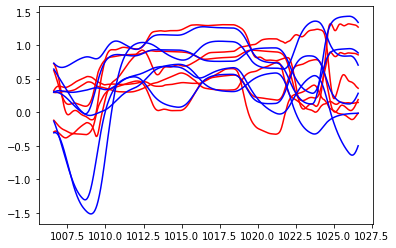

In [9]:
from matplotlib import pyplot as plt
plt.plot(data[0][3][0], data[0][4],'r-')
plt.plot(data[0][3][0], data[0][5],'b-')
plt.show()

In [12]:
system = rcopt.get_system('softrobot')

In [17]:
vpts = []
for ds in data:
    ts, Uts, pre = ds[3], ds[4], ds[5]
    vpt = rcopt.get_vptime(system, ts, Uts, pre)
    vpts.append(vpt)
print(vpts)

[0.4700033728758797, 0.49000351640250983, 0.5400038752190994, 0.8400060281187507, 0.23000165055623256, 0.3600025834793996, 0.6700048081422665, 0.3600025834793996]


In [18]:
import matplotlib
from matplotlib import pyplot as plt

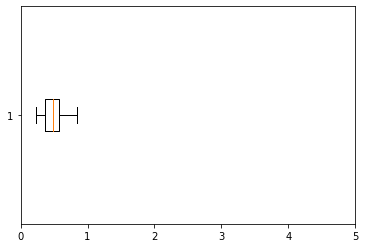

In [19]:
plt.boxplot(vpts, vert=False)
plt.xlim(0,5)
plt.show()

In [34]:
def true_brightness(A, axis=0):
    R,G,B = 0.4126, 0.4152, 0.2722
    return np.take(A, 0, axis=axis)*R + np.take(A, 1, axis=axis)*G + np.take(A, 2, axis=axis)*B

def scale_brightness(A):
    """Scales brightness to be the minimum"""
    br = true_brightness(A, axis=1)
    min_br = np.min(br)
    A = A.copy()
    A[:,:3] *= (min_br / br).reshape(-1,1)
    return A

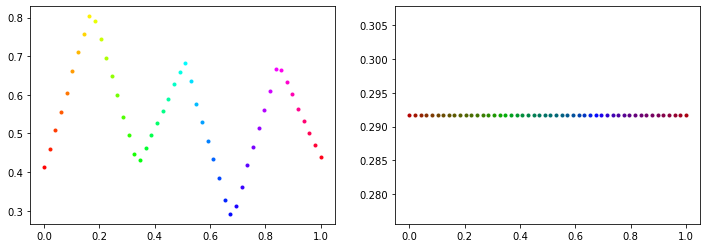

In [35]:
colors = plt.get_cmap('hsv')(np.linspace(0,1,50))
br = true_brightness(colors,axis=1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for x,y,c in zip(np.linspace(0,1,50),br,colors):
    plt.plot(x,y,'.',color=c)
    
plt.subplot(1,2,2)
rs_colors = scale_brightness(colors)
brc = true_brightness(rs_colors,axis=1)
for x,y,c in zip(np.linspace(0,1,50),brc,rs_colors):
    plt.plot(x,y,'.',color=c)
plt.show()